In [3]:
# Könyvtárak importálása
import numpy as np                   # numerikus műveletekhez
import pandas as pd                  # adatfeldolgozáshoz
import os                            # fájlok eléréséhez
from sklearn.model_selection import train_test_split # adatok felosztásához
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error          # teljesítményméréshez
from sklearn.preprocessing import StandardScaler, MinMaxScaler        # adatok standardizálásához, normalizálásához
from tensorflow.keras.losses import MeanSquaredError
import joblib # modellek mentéséhez
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import tensorflow as tf              # neurális háló építéséhez
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tcn import TCN
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
pip install keras-tcn

Note: you may need to restart the kernel to use updated packages.


In [4]:
base_path = "/kaggle/input/tzsde/tőzsde"  # Itt add meg a feltöltött fájlok mappáját

stock_prices = pd.read_csv(os.path.join(base_path, "train_files/stock_prices.csv"))
secondary_stock_prices = pd.read_csv(os.path.join(base_path, "train_files/secondary_stock_prices.csv"))
supplemental_prices = pd.read_csv(os.path.join(base_path, "supplemental_files/stock_prices.csv"))
supplemental_secondary_stock_prices = pd.read_csv(os.path.join(base_path, "supplemental_files/secondary_stock_prices.csv"))

# Adatok egyesítése (RowId megőrzésével)
stock_prices_combined = pd.concat([
    stock_prices,
    secondary_stock_prices,
    supplemental_prices,
    supplemental_secondary_stock_prices
], ignore_index=True)

# RowId mentése egy külön oszlopba
stock_prices_combined = stock_prices_combined.drop(['ExpectedDividend'], axis = 1)
stock_prices_combined['RowId'] = stock_prices_combined['RowId'].astype(str)  # Biztosítjuk, hogy szövegként kezelje

In [5]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

# --- Adatok előkészítése ---
# A Date oszlop átalakítása datetime típusra, majd rendezés részvényenként időrendben
stock_prices_combined['Date'] = pd.to_datetime(stock_prices_combined['Date'], format='%Y-%m-%d')
stock_prices_combined = stock_prices_combined.sort_values(['SecuritiesCode', 'Date']).reset_index(drop=True)

# --- Alap jellemzők létrehozása ---
stock_prices_combined['Daily_Range'] = stock_prices_combined['Close'] - stock_prices_combined['Open']
stock_prices_combined['Mean'] = (stock_prices_combined['High'] + stock_prices_combined['Low']) / 2
stock_prices_combined['Relative_Range'] = stock_prices_combined['Daily_Range'] / stock_prices_combined['Open']

# Végtelen értékek lecserélése NaN-ra, majd törlésük
stock_prices_combined.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_prices_combined.dropna(inplace=True)

# --- Rolling feature-ek létrehozása részvényenként ---
def add_rolling_features(df, window_sizes=[5, 10, 20]):
    for window in window_sizes:
        # Egyszerű mozgóátlag (SMA)
        df[f'SMA_{window}'] = df.groupby('SecuritiesCode')['Close']\
                                  .transform(lambda x: x.rolling(window, min_periods=window).mean())
        # Szórás (STD)
        df[f'STD_{window}'] = df.groupby('SecuritiesCode')['Close']\
                                  .transform(lambda x: x.rolling(window, min_periods=window).std())
        # Momentum (aktuális minus az elmozdult érték)
        df[f'Momentum_{window}'] = df.groupby('SecuritiesCode')['Close']\
                                       .transform(lambda x: x - x.shift(window))
    return df

stock_prices_combined = add_rolling_features(stock_prices_combined)

# --- RSI számítás ---
def compute_RSI(series, window=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.rolling(window, min_periods=window).mean()
    roll_down = down.rolling(window, min_periods=window).mean()
    RS = roll_up / roll_down
    return 100 - (100 / (1 + RS))

stock_prices_combined['RSI_14'] = stock_prices_combined.groupby('SecuritiesCode')['Close']\
                                                        .transform(lambda x: compute_RSI(x, window=14))

# Rolling számítások miatt keletkezett végtelen értékek/NaN-ek eltávolítása
stock_prices_combined.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_prices_combined.dropna(inplace=True)

# --- Új jellemzők beépítése ---

# 1. Exponenciális mozgóátlag (EMA)
for window in [5, 10, 20]:
    stock_prices_combined[f'EMA_{window}'] = stock_prices_combined.groupby('SecuritiesCode')['Close']\
                                                                   .transform(lambda x: x.ewm(span=window, adjust=False).mean())

# 2. MACD (Moving Average Convergence Divergence)
def compute_MACD(series, fast=12, slow=26):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    return ema_fast - ema_slow

stock_prices_combined['MACD'] = stock_prices_combined.groupby('SecuritiesCode')['Close']\
                                                      .transform(compute_MACD)

# 3. Bollinger szalagok (BB_upper, BB_lower)
def compute_bollinger_bands(series, window=20, num_std=2):
    sma = series.rolling(window).mean()
    std = series.rolling(window).std()
    upper_band = sma + (num_std * std)
    lower_band = sma - (num_std * std)
    df_bb = pd.DataFrame({'BB_upper': upper_band, 'BB_lower': lower_band})
    return df_bb

# A groupby.apply miatt a visszaadott DataFrame egy multi-index struktúrában lesz,
# ezért visszaállítjuk az indexeket, hogy illeszkedjenek az eredeti adathoz.
bb = stock_prices_combined.groupby('SecuritiesCode')['Close']\
        .apply(lambda x: compute_bollinger_bands(x)).reset_index(level=0, drop=True)
stock_prices_combined['BB_upper'] = bb['BB_upper']
stock_prices_combined['BB_lower'] = bb['BB_lower']

# 4. Dátum alapján levont jellemzők (hét napja, hónap)
stock_prices_combined['DayOfWeek'] = stock_prices_combined['Date'].dt.dayofweek
stock_prices_combined['Month'] = stock_prices_combined['Date'].dt.month

# 5. Historical Volatility: Log Return és 10 napos volatilitás
stock_prices_combined['LogReturn'] = stock_prices_combined.groupby('SecuritiesCode')['Close']\
                                                           .transform(lambda x: np.log(x / x.shift(1)))
stock_prices_combined['Volatility_10'] = stock_prices_combined.groupby('SecuritiesCode')['LogReturn']\
                                                              .transform(lambda x: x.rolling(10).std())

# 6. Sharpe-szerű hozam/volatilitás mutató (10 napos görbülettel)
stock_prices_combined['SharpeLike_10'] = stock_prices_combined.groupby('SecuritiesCode')['LogReturn']\
                                                              .transform(lambda x: x.rolling(10).mean() / (x.rolling(10).std() + 1e-6))

# 7. Gap az előző napi záróhoz (nyitóár - előző napi záró ár)
stock_prices_combined['Gap'] = stock_prices_combined.groupby('SecuritiesCode')\
                                                     .apply(lambda x: x['Open'] - x['Close'].shift(1))\
                                                     .reset_index(level=0, drop=True)

# 8. Volume change (forgalom százalékos változása)
stock_prices_combined['Volume_Change'] = stock_prices_combined.groupby('SecuritiesCode')['Volume']\
                                                               .transform(lambda x: x.pct_change())

# Még egyszer végtelen értékek és NaN-ek eltávolítása az összes új művelet után
stock_prices_combined.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_prices_combined.dropna(inplace=True)

# --- Skálázás ---
# Összeállítjuk a teljes jellemző listát: eredeti mérőszámok + rolling + technikai + új jellemzők
base_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Range', 'Mean', 'Relative_Range']

rolling_features = [f'SMA_{w}' for w in [5, 10, 20]] + \
                   [f'STD_{w}' for w in [5, 10, 20]] + \
                   [f'Momentum_{w}' for w in [5, 10, 20]]

technical_features = ['RSI_14', 'EMA_5', 'EMA_10', 'EMA_20', 'MACD', 'BB_upper', 'BB_lower']

extra_features = ['DayOfWeek', 'Month', 'Volatility_10', 'SharpeLike_10', 'Gap', 'Volume_Change']

unimportant_features = [
    'Gap', 'STD_20', 'Mean', 'Close', 'High', 'Daily_Range',
    'Momentum_10', 'EMA_20', 'EMA_10', 'SMA_20', 'SMA_10', 'SMA_5', 'Volume', 'STD_5', 'BB_upper', 'STD_10', 'EMA_5'
]

all_features = base_features + rolling_features + technical_features + extra_features

# Kevésbé fontos jellemzők kiszűrése az all_features listából
all_features = [f for f in all_features if f not in unimportant_features]

# Standardizálás: nullaközépű, egységszórású transzformáció (z-score)
scaler_standard = StandardScaler()
stock_prices_combined[all_features] = scaler_standard.fit_transform(stock_prices_combined[all_features])

# MinMax skálázás: értékek 0 és 1 közé
scaler_minmax = MinMaxScaler()
stock_prices_combined[all_features] = scaler_minmax.fit_transform(stock_prices_combined[all_features])

# Csak azon sorok megtartása, ahol a célváltozó (Target) is rendelkezésre áll
stock_prices_combined.dropna(subset=['Target'], inplace=True)

# Utolsó ellenőrzés a végtelen/NaN értékek eltávolítására
stock_prices_combined.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_prices_combined.dropna(inplace=True)

print("Adatok végső mérete:", stock_prices_combined.shape)

<ipython-input-5-424bde6ce90c>:98: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x['Open'] - x['Close'].shift(1))\


Adatok végső mérete: (4987384, 37)


In [6]:
features = ['Open', 'MACD', 'DayOfWeek', 'SharpeLike_10', 'Relative_Range', 'Momentum_20', 'RSI_14', 'Volatility_10', 'Month']

train_data = stock_prices_combined[stock_prices_combined['Date'] < '2021-01-01']
val_data = stock_prices_combined[(stock_prices_combined['Date'] >= '2021-01-01') & (stock_prices_combined['Date'] < '2022-01-01')]
test_data = stock_prices_combined[(stock_prices_combined['Date'] >= '2022-01-01') & (stock_prices_combined['Date'] < '2022-07-01')]

# A bemenet (X) és a cél (y) elkülönítése
X_train = train_data[features]
y_train = train_data['Target']
row_ids_train = train_data['RowId']

X_val = val_data[features]
y_val = val_data['Target']
row_ids_val = val_data['RowId']

X_test = test_data[features]
y_test = test_data['Target']
row_ids_test = test_data['RowId']

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (3550136, 9)
Validation shape: (972754, 9)
Test shape: (464494, 9)


In [ ]:
def save_predictions_with_ids(df_part, y_true, pred_ridge, pred_xgb, pred_lgb, pred_lstm, name):
    result = df_part[['RowId', 'Date', 'SecuritiesCode']].copy()
    result['Target']     = y_true.values
    result['Ridge_Pred'] = pred_ridge
    result['XGB_Pred']   = pred_xgb
    result['LGB_Pred']   = pred_lgb
    result['LSTM_Pred']  = pred_lstm
    result.to_csv(f'/kaggle/working/{name}_preds.csv', index=False)

In [7]:
# Lineáris regresszió (Ridge-gyel a stabilitás miatt)
linreg = Ridge(alpha=1.0)
linreg.fit(X_train, y_train)

train_pred_ridge = linreg.predict(X_train)
val_pred_ridge = linreg.predict(X_val)
test_pred_ridge = linreg.predict(X_test)

In [8]:
# Predikciók hozzáadása az adathalmazokhoz
X_train = X_train.copy()
X_train['Linear_Pred'] = train_pred_ridge
X_val = X_val.copy()
X_val['Linear_Pred'] = val_pred_ridge
X_test = X_test.copy()
X_test['Linear_Pred'] = test_pred_ridge

In [9]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist',     
    device='cuda',        
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

train_pred_xgb = xgb_model.predict(X_train)
val_pred_xgb = xgb_model.predict(X_val)
test_pred_xgb = xgb_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:54:00] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [10]:
# Predikciók hozzáadása az adathalmazokhoz
X_train = X_train.copy()
X_train['XGB_Pred'] = train_pred_xgb
X_val = X_val.copy()
X_val['XGB_Pred'] = val_pred_xgb
X_test = X_test.copy()
X_test['XGB_Pred'] = test_pred_xgb

In [11]:
# LightGBM modell létrehozása
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.0007,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

lgb_model = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_valid],
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=50)
    ]
)

# LightGBM predikciók a három adathalmazra
train_pred_lgb = lgb_model.predict(X_train, num_iteration=lgb_model.best_iteration)
val_pred_lgb = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)
test_pred_lgb = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 0.0243664
[100]	valid_0's rmse: 0.0243619
[150]	valid_0's rmse: 0.0243593
[200]	valid_0's rmse: 0.0243572
[250]	valid_0's rmse: 0.0243559
[300]	valid_0's rmse: 0.0243556
Early stopping, best iteration is:
[291]	valid_0's rmse: 0.0243555


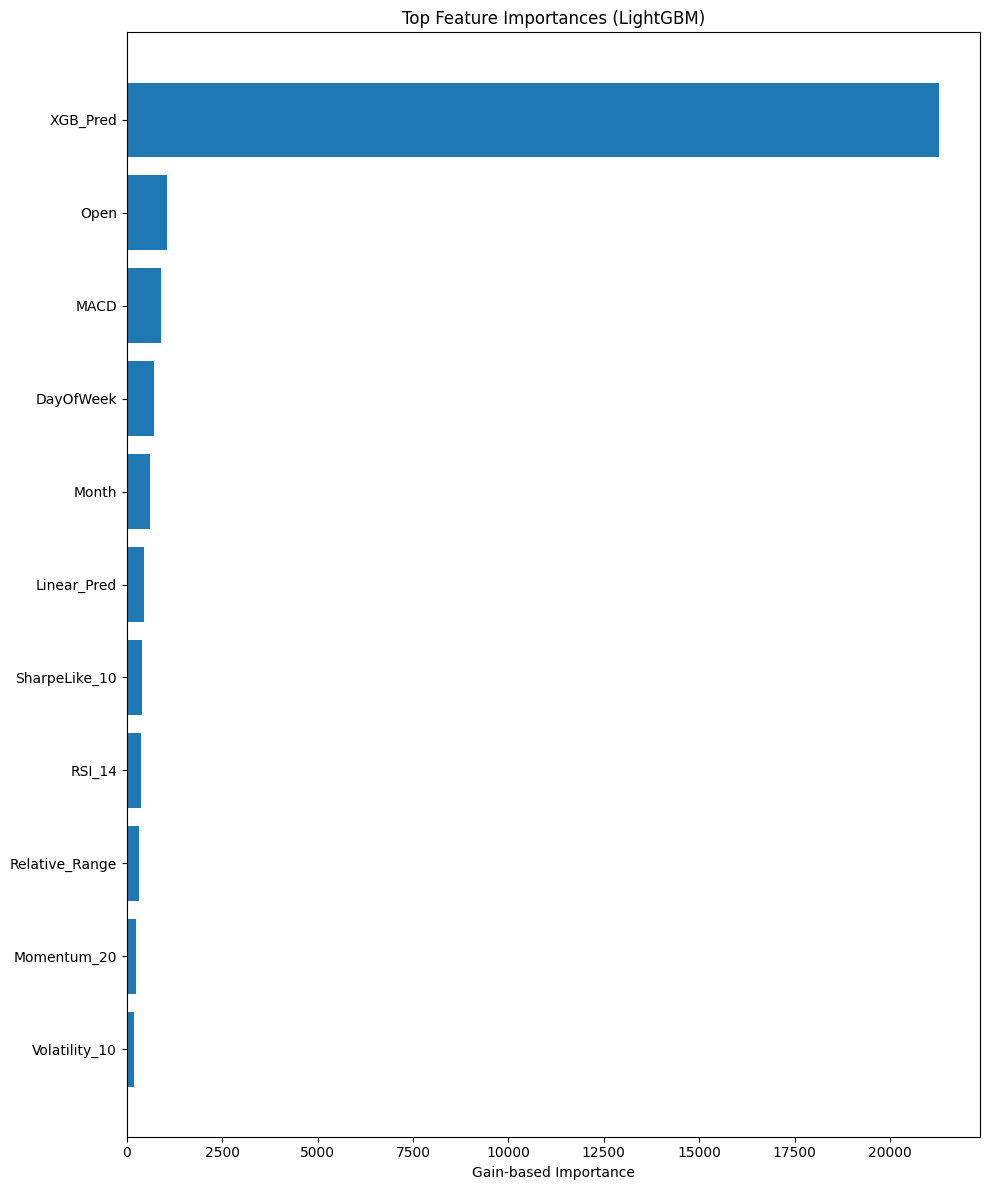

In [12]:
# Feature importance értékek
importance_values = lgb_model.feature_importance(importance_type='gain')  # vagy: 'split'
feature_names = X_train.columns

# DataFrame-be rendezés
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_values
}).sort_values(by='Importance', ascending=False)

# Legfontosabb jellemzők megjelenítése
plt.figure(figsize=(10, 12))
plt.barh(feature_importance_df['Feature'][:30][::-1], feature_importance_df['Importance'][:30][::-1])
plt.xlabel("Gain-based Importance")
plt.title("Top Feature Importances (LightGBM)")
plt.tight_layout()
plt.show()

In [13]:
# Predikciók hozzáadása feature-ként
X_train = X_train.copy()
X_train['LGBM_Pred'] = train_pred_lgb
X_val = X_val.copy()
X_val['LGBM_Pred'] = val_pred_lgb
X_test = X_test.copy()
X_test['LGBM_Pred'] = test_pred_lgb

In [14]:
selected_features = ['Linear_Pred', 'XGB_Pred', 'LGBM_Pred']

X_train = X_train[selected_features].copy()
X_val = X_val[selected_features].copy()
X_test = X_test[selected_features].copy()

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [15]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [16]:
def create_sequences(X, y, window_size=20):
    X_seq, y_seq = [], []
    for i in range(window_size, len(X)):
        X_seq.append(X[i-window_size:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

window_size = 20
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, window_size)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val.values, window_size)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, window_size)

In [ ]:
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(window_size, X_train_seq.shape[2])),
    BatchNormalization(),
    Dropout(0.4),

    Bidirectional(LSTM(64, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(32)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=7,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/7
   724/110942 ━━━━━━━━━━━━━━━━━━━━ 25:35 14ms/step - loss: 0.7232

In [18]:
train_pred_lstm = model.predict(X_train_seq)
val_pred_lstm = model.predict(X_val_seq)
test_pred_lstm = model.predict(X_test_seq)

110942/110942 ━━━━━━━━━━━━━━━━━━━━ 428s 4ms/step
30398/30398 ━━━━━━━━━━━━━━━━━━━━ 117s 4ms/step
14515/14515 ━━━━━━━━━━━━━━━━━━━━ 56s 4ms/step


In [19]:
X_train_lstm = X_train.copy().iloc[window_size:].copy()
X_val_lstm = X_val.copy().iloc[window_size:].copy()
X_test_lstm = X_test.copy().iloc[window_size:].copy()

X_train_lstm['LSTM_Pred'] = train_pred_lstm
X_val_lstm['LSTM_Pred'] = val_pred_lstm
X_test_lstm['LSTM_Pred'] = test_pred_lstm

In [39]:
def expand_and_fill(preds, original_df, window_size):
    # predikciókat NaN-nal bővítjük ki előrefelé
    full = np.full((len(original_df),), np.nan)
    full[window_size:] = preds.flatten()
    return full

In [40]:
train_pred_lstm_full = expand_and_fill(train_pred_lstm, X_train, window_size)
val_pred_lstm_full   = expand_and_fill(val_pred_lstm,   X_val,   window_size)
test_pred_lstm_full  = expand_and_fill(test_pred_lstm,  X_test,  window_size)

In [41]:
lst_median = np.nanmedian(train_pred_lstm_full)
train_pred_lstm_full = np.where(np.isnan(train_pred_lstm_full), lst_median, train_pred_lstm_full)
val_pred_lstm_full   = np.where(np.isnan(val_pred_lstm_full),   lst_median, val_pred_lstm_full)
test_pred_lstm_full  = np.where(np.isnan(test_pred_lstm_full),  lst_median, test_pred_lstm_full)

In [42]:
X_train['LSTM_Pred'] = train_pred_lstm_full
X_val['LSTM_Pred'] = val_pred_lstm_full
X_test['LSTM_Pred'] = test_pred_lstm_full

In [ ]:
lgb_model.save_model('/kaggle/working/lgb_model.txt')
joblib.dump(linreg, '/kaggle/working/linreg_model.pkl')
joblib.dump(xgb_model, '/kaggle/working/xgb_model.pkl')
model.save('/kaggle/working/lstm_model.h5')

In [ ]:
save_predictions_with_ids(
    train_data, y_train,
    train_pred_ridge, train_pred_xgb, train_pred_lgb, train_pred_lstm_full,
    name='train'
)
save_predictions_with_ids(
    val_data, y_val,
    val_pred_ridge, val_pred_xgb, val_pred_lgb, val_pred_lstm_full,
    name='val'
)
save_predictions_with_ids(
    test_data, y_test,
    test_pred_ridge, test_pred_xgb, test_pred_lgb, test_pred_lstm_full,
    name='test'
)

In [32]:
# A teljes DataFrame méretű másolat
X_train_lstm = X_train.copy()
X_val_lstm = X_val.copy()
X_test_lstm = X_test.copy()

# Az LSTM predikciókat a window_size utáni sorokhoz adjuk hozzá
X_train_lstm.loc[X_train_lstm.index[window_size:], 'LSTM_Pred'] = train_pred_lstm.flatten()
X_val_lstm.loc[X_val_lstm.index[window_size:], 'LSTM_Pred'] = val_pred_lstm.flatten()
X_test_lstm.loc[X_test_lstm.index[window_size:], 'LSTM_Pred'] = test_pred_lstm.flatten()

In [33]:
# Medián alapján történő kitöltés
X_train_lstm['LSTM_Pred'].fillna(X_train_lstm['LSTM_Pred'].median(), inplace=True)
X_val_lstm['LSTM_Pred'].fillna(X_train_lstm['LSTM_Pred'].median(), inplace=True)
X_test_lstm['LSTM_Pred'].fillna(X_train_lstm['LSTM_Pred'].median(), inplace=True)

<ipython-input-33-20ddc5fc80c4>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_lstm['LSTM_Pred'].fillna(X_train_lstm['LSTM_Pred'].median(), inplace=True)
<ipython-input-33-20ddc5fc80c4>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].meth

In [39]:
model = Sequential([
    TCN(input_shape=(window_size, X_train_seq.shape[2]), 
        nb_filters=64, 
        kernel_size=3, 
        dilations=[1, 2], 
        dropout_rate=0.2,
        return_sequences=False),
    BatchNormalization(),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=1e-3, clipnorm=1.0), loss='mae')


callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=5,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.10/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Epoch 1/5
110942/110942 ━━━━━━━━━━━━━━━━━━━━ 275s 2ms/step - loss: 0.0253 - val_loss: 0.0147 - learning_rate: 0.0010
Epoch 2/5
110942/110942 ━━━━━━━━━━━━━━━━━━━━ 264s 2ms/step - loss: 0.0160 - val_loss: 0.0146 - learning_rate: 0.0010
Epoch 3/5
110942/110942 ━━━━━━━━━━━━━━━━━━━━ 263s 2ms/step - loss: 0.0160 - val_loss: 0.0146 - learning_rate: 0.0010
Epoch 4/5
110942/110942 ━━━━━━━━━━━━━━━━━━━━ 264s 2ms/step - loss: 0.0160 - val_loss: 0.0146 - learning_rate: 0.0010
Epoch 5/5
110942/110942 ━━━━━━━━━━━━━━━━━━━━ 264s 2ms/step - loss: 0.0160 - val_loss: 0.0146 - learning_rate: 0.0010


In [40]:
train_pred_tcn = model.predict(X_train_seq)
val_pred_tcn = model.predict(X_val_seq)
test_pred_tcn = model.predict(X_test_seq)

110942/110942 ━━━━━━━━━━━━━━━━━━━━ 137s 1ms/step
30398/30398 ━━━━━━━━━━━━━━━━━━━━ 38s 1ms/step
14515/14515 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


In [41]:
X_train_tcn = X_train.copy().iloc[window_size:].copy()
X_val_tcn = X_val.copy().iloc[window_size:].copy()
X_test_tcn = X_test.copy().iloc[window_size:].copy()

X_train_tcn['TCN_Pred'] = train_pred_tcn
X_val_tcn['TCN_Pred'] = val_pred_tcn
X_test_tcn['TCN_Pred'] = test_pred_tcn

In [20]:
# Előrejelzés a validációs adatokra és rangsorolás (az értékelő függvényhez)
# Itt most a modellünk előrejelzett Target értékeit használjuk a rangsoroláshoz.
val_df = val_data[['Date', 'SecuritiesCode']].copy()
val_df['True_Target'] = y_val.values
val_df['Predicted_Target'] = val_pred_lgb

# Minden napon belül rangsoroljuk a részvényeket, a legmagasabb predikciót 0-dik rank-nak vesszük
val_df['Rank'] = val_df.groupby('Date')['Predicted_Target'].rank(ascending=False, method='first') - 1

In [21]:
# Tesztadatokhoz igazított DataFrame (csak Date és SecuritiesCode kell)
test_df = test_data[['Date', 'SecuritiesCode']].copy()

# Valódi célérték és predikció hozzárendelése
test_df['True_Target'] = y_test.values
test_df['Predicted_Target'] = test_pred_lgb

# Rangszámítás naponta, legjobb predikció kapja a 0-dik helyet
test_df['Rank'] = test_df.groupby('Date')['Predicted_Target'].rank(ascending=False, method='first') - 1

In [23]:
# Számoljuk ki a validációs Sharpe-ratio-t a verseny specifikus függvényével:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    def _calc_spread_return_per_day(df_day, portfolio_size, toprank_weight_ratio):
        assert df_day['Rank'].min() == 0
        assert df_day['Rank'].max() == len(df_day['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df_day.sort_values(by='Rank')['True_Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df_day.sort_values(by='Rank', ascending=False)['True_Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    daily_returns = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = daily_returns.mean() / daily_returns.std()
    return sharpe_ratio

In [24]:
# Függvény a napi spread return kiszámolásához (ugyanaz, mint korábban, de most egy napra lebontva)
def calc_daily_spread_return(df_day, portfolio_size=200, toprank_weight_ratio=2):
    # Győződjünk meg róla, hogy a predikált rangok 0-tól kezdődnek
    assert df_day['Rank'].min() == 0
    assert df_day['Rank'].max() == len(df_day) - 1
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    purchase = (df_day.sort_values(by='Rank')['True_Target'][:portfolio_size] * weights).sum() / weights.mean()
    short = (df_day.sort_values(by='Rank', ascending=False)['True_Target'][:portfolio_size] * weights).sum() / weights.mean()
    return purchase - short

# Hit Rate @ k számítása SecuritiesCode alapján
def hit_rate_at_k(df, k, mode="top"):
    if mode == "top":
        top_k_actual = set(df.nsmallest(k, 'Actual_Rank')['SecuritiesCode'])
        top_k_pred = set(df.nsmallest(k, 'Rank')['SecuritiesCode'])
    elif mode == "bottom":
        top_k_actual = set(df.nlargest(k, 'Actual_Rank')['SecuritiesCode'])
        top_k_pred = set(df.nlargest(k, 'Rank')['SecuritiesCode'])
    else:
        raise ValueError("mode should be 'top' or 'bottom'")
    return len(top_k_actual & top_k_pred) / k


calc_spread_return_sharpe(val_df)

# Lista a napi metrikáknak
daily_metrics = []

# Csoportosítás dátum szerint (feltételezve, hogy a valósítás az érvényesítési adatokon (val_df) történik)
for date, group in val_df.groupby('Date'):

    if len(group) < 400:  
        continue

    # Másoljuk a csoportot a biztonságos módosítás érdekében
    group = group.copy()
    
    # Számoljuk ki a napi spread return-t a predikált rangok alapján
    daily_spread_return = calc_daily_spread_return(group, portfolio_size=200, toprank_weight_ratio=2)
    
    # Számoljuk ki a valódi rangot (azaz a True_Target alapján)
    # Itt a legmagasabb True_Target kapja a 0-ás rangot (csökkenő sorrendben)
    group['Actual_Rank'] = group.groupby('Date')['True_Target']\
                                  .rank(ascending=False, method='first') - 1

    # A predikált rangot már korábban kiszámoltuk és a "Rank" oszlopban van.
    # Számoljuk ki a hit rate @ 200 értékeket mind a top, mind a bottom oldalon.
    hit_rate_top_200 = hit_rate_at_k(group, k=200, mode="top")
    hit_rate_bottom_200 = hit_rate_at_k(group, k=200, mode="bottom")

    daily_metrics.append({
        'Date': date,
        'Daily_Spread_Return': daily_spread_return,
        'HitRate@Top200': hit_rate_top_200,
        'HitRate@Bottom200': hit_rate_bottom_200,
        'Num_Stocks': len(group)
    })

# Hozzuk létre a napi metrikák DataFrame-jét és rendezzük dátum szerint
daily_metrics_df = pd.DataFrame(daily_metrics).sort_values('Date')

# Aggregált Sharpe arány a napi spread return-okból
overall_sharpe = daily_metrics_df['Daily_Spread_Return'].mean() / daily_metrics_df['Daily_Spread_Return'].std()

print("Aggregált (Validation) Sharpe Score:", overall_sharpe)
print("\nNéhány napi metrika:")
print(daily_metrics_df.head())

# Átlagos Hit Rate értékek
avg_hit_top = daily_metrics_df['HitRate@Top200'].mean()
avg_hit_bottom = daily_metrics_df['HitRate@Bottom200'].mean()

print(f"\nÁtlagos HitRate@Top200: {avg_hit_top:.4f}")
print(f"Átlagos HitRate@Bottom200: {avg_hit_bottom:.4f}")

<ipython-input-23-ab417a6cadc8>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_returns = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)


Aggregált (Validation) Sharpe Score: 0.21508953164538397

Néhány napi metrika:
        Date  Daily_Spread_Return  HitRate@Top200  HitRate@Bottom200  \
0 2021-01-04             1.846847           0.165              0.165   
1 2021-01-05            -0.734520           0.100              0.105   
2 2021-01-06             1.161483           0.105              0.065   
3 2021-01-07            -1.206293           0.120              0.030   
4 2021-01-08            -1.431613           0.065              0.135   

   Num_Stocks  
0        3956  
1        3936  
2        3937  
3        3935  
4        3950  

Átlagos HitRate@Top200: 0.0954
Átlagos HitRate@Bottom200: 0.1011


In [25]:
calc_spread_return_sharpe(test_df)

# Lista a napi metrikáknak
daily_metrics = []

# Csoportosítás dátum szerint (feltételezve, hogy a valósítás az érvényesítési adatokon (val_df) történik)
for date, group in test_df.groupby('Date'):

    if len(group) < 400:  
        continue

    # Másoljuk a csoportot a biztonságos módosítás érdekében
    group = group.copy()
    
    # Számoljuk ki a napi spread return-t a predikált rangok alapján
    daily_spread_return = calc_daily_spread_return(group, portfolio_size=200, toprank_weight_ratio=2)
    
    # Számoljuk ki a valódi rangot (azaz a True_Target alapján)
    # Itt a legmagasabb True_Target kapja a 0-ás rangot (csökkenő sorrendben)
    group['Actual_Rank'] = group.groupby('Date')['True_Target']\
                                  .rank(ascending=False, method='first') - 1

    # A predikált rangot már korábban kiszámoltuk és a "Rank" oszlopban van.
    # Számoljuk ki a hit rate @ 200 értékeket mind a top, mind a bottom oldalon.
    hit_rate_top_200 = hit_rate_at_k(group, k=200, mode="top")
    hit_rate_bottom_200 = hit_rate_at_k(group, k=200, mode="bottom")

    daily_metrics.append({
        'Date': date,
        'Daily_Spread_Return': daily_spread_return,
        'HitRate@Top200': hit_rate_top_200,
        'HitRate@Bottom200': hit_rate_bottom_200,
        'Num_Stocks': len(group)
    })

# Hozzuk létre a napi metrikák DataFrame-jét és rendezzük dátum szerint
daily_metrics_df = pd.DataFrame(daily_metrics).sort_values('Date')

# Aggregált Sharpe arány a napi spread return-okból
overall_sharpe = daily_metrics_df['Daily_Spread_Return'].mean() / daily_metrics_df['Daily_Spread_Return'].std()

print("Aggregált (Test) Sharpe Score:", overall_sharpe)
print("\nNéhány napi metrika:")
print(daily_metrics_df.head())

# Átlagos Hit Rate értékek
avg_hit_top = daily_metrics_df['HitRate@Top200'].mean()
avg_hit_bottom = daily_metrics_df['HitRate@Bottom200'].mean()

print(f"\nÁtlagos HitRate@Top200: {avg_hit_top:.4f}")
print(f"Átlagos HitRate@Bottom200: {avg_hit_bottom:.4f}")

<ipython-input-23-ab417a6cadc8>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_returns = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)


Aggregált (Test) Sharpe Score: -0.05229701906932061

Néhány napi metrika:
        Date  Daily_Spread_Return  HitRate@Top200  HitRate@Bottom200  \
0 2022-01-04            -2.954625           0.030              0.060   
1 2022-01-05             0.758407           0.115              0.075   
2 2022-01-06            -1.952082           0.095              0.030   
3 2022-01-07             3.547390           0.190              0.090   
4 2022-01-11            -1.055648           0.040              0.140   

   Num_Stocks  
0        4034  
1        4020  
2        4015  
3        4008  
4        3997  

Átlagos HitRate@Top200: 0.1077
Átlagos HitRate@Bottom200: 0.0900


In [ ]:
# Megjeleníti az adott napra a részvények tényleges és előrejelzett rangsorolását

def display_daily_ranking(date_str, df): 
    target_date = pd.to_datetime(date_str)
    day_df = df[df['Date'] == target_date].copy()

    if day_df.empty:
        print(f"Nincs adat a {date_str} napra.")
        return None

    # Aktuális rangsor a True_Target alapján
    actual_df = day_df[['SecuritiesCode', 'True_Target']].copy()
    actual_df = actual_df.sort_values(by='True_Target', ascending=False).reset_index(drop=True)
    actual_df['Actual_Rank'] = np.arange(len(actual_df))

    # Predikált rangsor a Predicted_Target alapján
    predicted_df = day_df[['SecuritiesCode', 'Predicted_Target']].copy()
    predicted_df = predicted_df.sort_values(by='Predicted_Target', ascending=False).reset_index(drop=True)
    predicted_df['Pred_Rank'] = np.arange(len(predicted_df))

    # Összefűzés a SecuritiesCode alapján
    merged_ranking = pd.merge(actual_df, predicted_df, on='SecuritiesCode', how='outer')
    merged_ranking.sort_values(by='Actual_Rank', inplace=True)

    return merged_ranking[['SecuritiesCode', 'Actual_Rank', 'Pred_Rank']]

# Használat:
date_of_interest = "2021-01-08"
ranking_comparison = display_daily_ranking(date_of_interest, val_df)
print(f"\nRangsorolás a {date_of_interest} napra:")
print(ranking_comparison)

In [49]:
# A validációs DataFrame szinkronizálása a predikciókkal
val_df = val_data[['Date', 'SecuritiesCode']].copy()
y_val_lstm_full = y_val.copy()
val_df['True_Target'] = y_val_lstm_full.values
val_df['Predicted_Target'] = val_pred_lstm_full

# Minden napon belül rangsoroljuk a részvényeket
val_df['Rank'] = val_df.groupby('Date')['Predicted_Target'].rank(ascending=False, method='first') - 1

In [51]:
# A validációs DataFrame szinkronizálása a predikciókkal
test_df = test_data[['Date', 'SecuritiesCode']].copy()
y_test_lstm_full = y_test.copy()
test_df['True_Target'] = y_test_lstm_full.values
test_df['Predicted_Target'] = test_pred_lstm_full

# Minden napon belül rangsoroljuk a részvényeket
test_df['Rank'] = test_df.groupby('Date')['Predicted_Target'].rank(ascending=False, method='first') - 1

In [52]:
calc_spread_return_sharpe(val_df)

# Lista a napi metrikáknak
daily_metrics = []

# Csoportosítás dátum szerint (feltételezve, hogy a valósítás az érvényesítési adatokon (val_df) történik)
for date, group in val_df.groupby('Date'):

    if len(group) < 400:  
        continue

    # Másoljuk a csoportot a biztonságos módosítás érdekében
    group = group.copy()
    
    # Számoljuk ki a napi spread return-t a predikált rangok alapján
    daily_spread_return = calc_daily_spread_return(group, portfolio_size=200, toprank_weight_ratio=2)
    
    # Számoljuk ki a valódi rangot (azaz a True_Target alapján)
    # Itt a legmagasabb True_Target kapja a 0-ás rangot (csökkenő sorrendben)
    group['Actual_Rank'] = group.groupby('Date')['True_Target']\
                                  .rank(ascending=False, method='first') - 1

    # A predikált rangot már korábban kiszámoltuk és a "Rank" oszlopban van.
    # Számoljuk ki a hit rate @ 200 értékeket mind a top, mind a bottom oldalon.
    hit_rate_top_200 = hit_rate_at_k(group, k=200, mode="top")
    hit_rate_bottom_200 = hit_rate_at_k(group, k=200, mode="bottom")

    daily_metrics.append({
        'Date': date,
        'Daily_Spread_Return': daily_spread_return,
        'HitRate@Top200': hit_rate_top_200,
        'HitRate@Bottom200': hit_rate_bottom_200,
        'Num_Stocks': len(group)
    })

# Hozzuk létre a napi metrikák DataFrame-jét és rendezzük dátum szerint
daily_metrics_df = pd.DataFrame(daily_metrics).sort_values('Date')

# Aggregált Sharpe arány a napi spread return-okból
overall_sharpe = daily_metrics_df['Daily_Spread_Return'].mean() / daily_metrics_df['Daily_Spread_Return'].std()

print("Aggregált (Validation) Sharpe Score:", overall_sharpe)
print("\nNéhány napi metrika:")
print(daily_metrics_df.head())

# Átlagos Hit Rate értékek
avg_hit_top = daily_metrics_df['HitRate@Top200'].mean()
avg_hit_bottom = daily_metrics_df['HitRate@Bottom200'].mean()

print(f"\nÁtlagos HitRate@Top200: {avg_hit_top:.4f}")
print(f"Átlagos HitRate@Bottom200: {avg_hit_bottom:.4f}")

<ipython-input-23-ab417a6cadc8>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_returns = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)


Aggregált (Validation) Sharpe Score: 0.06211731897516782

Néhány napi metrika:
        Date  Daily_Spread_Return  HitRate@Top200  HitRate@Bottom200  \
0 2021-01-04            -0.246027           0.060              0.030   
1 2021-01-05             1.052469           0.045              0.115   
2 2021-01-06             0.488707           0.055              0.050   
3 2021-01-07             0.622812           0.060              0.065   
4 2021-01-08            -0.504892           0.025              0.040   

   Num_Stocks  
0        3956  
1        3936  
2        3937  
3        3935  
4        3950  

Átlagos HitRate@Top200: 0.0674
Átlagos HitRate@Bottom200: 0.0528


In [53]:
calc_spread_return_sharpe(test_df)

# Lista a napi metrikáknak
daily_metrics = []

# Csoportosítás dátum szerint (feltételezve, hogy a valósítás az érvényesítési adatokon (val_df) történik)
for date, group in test_df.groupby('Date'):

    if len(group) < 400:  
        continue

    # Másoljuk a csoportot a biztonságos módosítás érdekében
    group = group.copy()
    
    # Számoljuk ki a napi spread return-t a predikált rangok alapján
    daily_spread_return = calc_daily_spread_return(group, portfolio_size=200, toprank_weight_ratio=2)
    
    # Számoljuk ki a valódi rangot (azaz a True_Target alapján)
    # Itt a legmagasabb True_Target kapja a 0-ás rangot (csökkenő sorrendben)
    group['Actual_Rank'] = group.groupby('Date')['True_Target']\
                                  .rank(ascending=False, method='first') - 1

    # A predikált rangot már korábban kiszámoltuk és a "Rank" oszlopban van.
    # Számoljuk ki a hit rate @ 200 értékeket mind a top, mind a bottom oldalon.
    hit_rate_top_200 = hit_rate_at_k(group, k=200, mode="top")
    hit_rate_bottom_200 = hit_rate_at_k(group, k=200, mode="bottom")

    daily_metrics.append({
        'Date': date,
        'Daily_Spread_Return': daily_spread_return,
        'HitRate@Top200': hit_rate_top_200,
        'HitRate@Bottom200': hit_rate_bottom_200,
        'Num_Stocks': len(group)
    })

# Hozzuk létre a napi metrikák DataFrame-jét és rendezzük dátum szerint
daily_metrics_df = pd.DataFrame(daily_metrics).sort_values('Date')

# Aggregált Sharpe arány a napi spread return-okból
overall_sharpe = daily_metrics_df['Daily_Spread_Return'].mean() / daily_metrics_df['Daily_Spread_Return'].std()

print("Aggregált (Test) Sharpe Score:", overall_sharpe)
print("\nNéhány napi metrika:")
print(daily_metrics_df.head())

# Átlagos Hit Rate értékek
avg_hit_top = daily_metrics_df['HitRate@Top200'].mean()
avg_hit_bottom = daily_metrics_df['HitRate@Bottom200'].mean()

print(f"\nÁtlagos HitRate@Top200: {avg_hit_top:.4f}")
print(f"Átlagos HitRate@Bottom200: {avg_hit_bottom:.4f}")

<ipython-input-23-ab417a6cadc8>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_returns = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)


Aggregált (Test) Sharpe Score: -0.03483388097090228

Néhány napi metrika:
        Date  Daily_Spread_Return  HitRate@Top200  HitRate@Bottom200  \
0 2022-01-04             0.576604           0.045              0.065   
1 2022-01-05            -0.598958           0.050              0.025   
2 2022-01-06            -0.066992           0.060              0.055   
3 2022-01-07             0.276247           0.035              0.055   
4 2022-01-11            -0.096694           0.045              0.040   

   Num_Stocks  
0        4034  
1        4020  
2        4015  
3        4008  
4        3997  

Átlagos HitRate@Top200: 0.0643
Átlagos HitRate@Bottom200: 0.0521


In [43]:
val_df = val_data[['Date', 'SecuritiesCode']].copy().iloc[window_size:].copy()
y_val_tcn = y_val[window_size:].copy()
val_df['True_Target'] = y_val_tcn.values
val_df['Predicted_Target'] = val_pred_tcn

# Minden napon belül rangsoroljuk a részvényeket
val_df['Rank'] = val_df.groupby('Date')['Predicted_Target'].rank(ascending=False, method='first') - 1

In [44]:
test_df = test_data[['Date', 'SecuritiesCode']].copy().iloc[window_size:].copy()
y_test_tcn = y_test[window_size:].copy()
test_df['True_Target'] = y_test_tcn.values
test_df['Predicted_Target'] = test_pred_tcn

# Minden napon belül rangsoroljuk a részvényeket
test_df['Rank'] = test_df.groupby('Date')['Predicted_Target'].rank(ascending=False, method='first') - 1

In [45]:
calc_spread_return_sharpe(val_df)

# Lista a napi metrikáknak
daily_metrics = []

# Csoportosítás dátum szerint (feltételezve, hogy a valósítás az érvényesítési adatokon (val_df) történik)
for date, group in val_df.groupby('Date'):

    if len(group) < 400:  
        continue

    # Másoljuk a csoportot a biztonságos módosítás érdekében
    group = group.copy()
    
    # Számoljuk ki a napi spread return-t a predikált rangok alapján
    daily_spread_return = calc_daily_spread_return(group, portfolio_size=200, toprank_weight_ratio=2)
    
    # Számoljuk ki a valódi rangot (azaz a True_Target alapján)
    # Itt a legmagasabb True_Target kapja a 0-ás rangot (csökkenő sorrendben)
    group['Actual_Rank'] = group.groupby('Date')['True_Target']\
                                  .rank(ascending=False, method='first') - 1

    # A predikált rangot már korábban kiszámoltuk és a "Rank" oszlopban van.
    # Számoljuk ki a hit rate @ 200 értékeket mind a top, mind a bottom oldalon.
    hit_rate_top_200 = hit_rate_at_k(group, k=200, mode="top")
    hit_rate_bottom_200 = hit_rate_at_k(group, k=200, mode="bottom")

    daily_metrics.append({
        'Date': date,
        'Daily_Spread_Return': daily_spread_return,
        'HitRate@Top200': hit_rate_top_200,
        'HitRate@Bottom200': hit_rate_bottom_200,
        'Num_Stocks': len(group)
    })

# Hozzuk létre a napi metrikák DataFrame-jét és rendezzük dátum szerint
daily_metrics_df = pd.DataFrame(daily_metrics).sort_values('Date')

# Aggregált Sharpe arány a napi spread return-okból
overall_sharpe = daily_metrics_df['Daily_Spread_Return'].mean() / daily_metrics_df['Daily_Spread_Return'].std()

print("Aggregált (Validation) Sharpe Score:", overall_sharpe)
print("\nNéhány napi metrika:")
print(daily_metrics_df.head())

# Átlagos Hit Rate értékek
avg_hit_top = daily_metrics_df['HitRate@Top200'].mean()
avg_hit_bottom = daily_metrics_df['HitRate@Bottom200'].mean()

print(f"\nÁtlagos HitRate@Top200: {avg_hit_top:.4f}")
print(f"Átlagos HitRate@Bottom200: {avg_hit_bottom:.4f}")

<ipython-input-24-ab417a6cadc8>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_returns = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)


Aggregált (Validation) Sharpe Score: 0.014164025074722334

Néhány napi metrika:
        Date  Daily_Spread_Return  HitRate@Top200  HitRate@Bottom200  \
0 2021-01-04            -0.342746           0.075              0.060   
1 2021-01-05            -0.012077           0.040              0.055   
2 2021-01-06            -1.951034           0.020              0.085   
3 2021-01-07             0.604952           0.060              0.110   
4 2021-01-08             0.332211           0.030              0.065   

   Num_Stocks  
0        3955  
1        3935  
2        3936  
3        3934  
4        3949  

Átlagos HitRate@Top200: 0.0676
Átlagos HitRate@Bottom200: 0.0624


In [27]:
calc_spread_return_sharpe(test_df)

# Lista a napi metrikáknak
daily_metrics = []

# Csoportosítás dátum szerint (feltételezve, hogy a valósítás az érvényesítési adatokon (val_df) történik)
for date, group in test_df.groupby('Date'):

    if len(group) < 400:  
        continue

    # Másoljuk a csoportot a biztonságos módosítás érdekében
    group = group.copy()
    
    # Számoljuk ki a napi spread return-t a predikált rangok alapján
    daily_spread_return = calc_daily_spread_return(group, portfolio_size=200, toprank_weight_ratio=2)
    
    # Számoljuk ki a valódi rangot (azaz a True_Target alapján)
    # Itt a legmagasabb True_Target kapja a 0-ás rangot (csökkenő sorrendben)
    group['Actual_Rank'] = group.groupby('Date')['True_Target']\
                                  .rank(ascending=False, method='first') - 1

    # A predikált rangot már korábban kiszámoltuk és a "Rank" oszlopban van.
    # Számoljuk ki a hit rate @ 200 értékeket mind a top, mind a bottom oldalon.
    hit_rate_top_200 = hit_rate_at_k(group, k=200, mode="top")
    hit_rate_bottom_200 = hit_rate_at_k(group, k=200, mode="bottom")

    daily_metrics.append({
        'Date': date,
        'Daily_Spread_Return': daily_spread_return,
        'HitRate@Top200': hit_rate_top_200,
        'HitRate@Bottom200': hit_rate_bottom_200,
        'Num_Stocks': len(group)
    })

# Hozzuk létre a napi metrikák DataFrame-jét és rendezzük dátum szerint
daily_metrics_df = pd.DataFrame(daily_metrics).sort_values('Date')

# Aggregált Sharpe arány a napi spread return-okból
overall_sharpe = daily_metrics_df['Daily_Spread_Return'].mean() / daily_metrics_df['Daily_Spread_Return'].std()

print("Aggregált (Test) Sharpe Score:", overall_sharpe)
print("\nNéhány napi metrika:")
print(daily_metrics_df.head())

# Átlagos Hit Rate értékek
avg_hit_top = daily_metrics_df['HitRate@Top200'].mean()
avg_hit_bottom = daily_metrics_df['HitRate@Bottom200'].mean()

print(f"\nÁtlagos HitRate@Top200: {avg_hit_top:.4f}")
print(f"Átlagos HitRate@Bottom200: {avg_hit_bottom:.4f}")

<ipython-input-21-ab417a6cadc8>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_returns = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)


Aggregált (Test) Sharpe Score: -0.11939791395389057

Néhány napi metrika:
        Date  Daily_Spread_Return  HitRate@Top200  HitRate@Bottom200  \
0 2022-01-04             0.945064           0.050              0.040   
1 2022-01-05            -0.040143           0.045              0.015   
2 2022-01-06             0.194032           0.015              0.080   
3 2022-01-07            -0.255251           0.030              0.045   
4 2022-01-11             0.075608           0.040              0.040   

   Num_Stocks  
0        4033  
1        4019  
2        4014  
3        4007  
4        3996  

Átlagos HitRate@Top200: 0.0586
Átlagos HitRate@Bottom200: 0.0536
